In [1]:
import scipy.io as spio
import numpy as np
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import sqlalchemy as sa
import pyodbc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import foldnorm
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy import integrate
from matplotlib.ticker import ScalarFormatter
import random
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerErrorbar
import json

class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"

plt.style.use('lexi_plt_style.mplstyle')

In [2]:
def write_json(data, file_name):
    with open (file_name, 'w') as file:
        json.dump(data, file, indent = 4)

def open_json(file_name):
    with open (file_name) as file:
        return json.load(file)

In [3]:
conn_str = (
    r'driver={SQL Server};'
    r'server=Desktop_Name\SQLEXPRESS;' #update with the path to your server
    r'database=Database_name;' #update with the name of your database
    r'trusted_connection=yes;'
    )

#using SQLAlchemy to avoid a UserWarning
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_str})
engine = create_engine(connection_url) #create SQLAlchemy engine object

cnxn = pyodbc.connect(conn_str) #connect to server using pyodbc
cursor = cnxn.cursor()

def run_quary(quary_str):
    '''Run a quary and return the output as a pandas datafrme

    Args:
        quary_str (str): quary string (not case sensitive, SQL strings need to be enclosed in single quotes)

    Returns:
        dataframe: quary output
    '''
    with engine.begin() as conn:
        return pd.read_sql_query(sa.text(quary_str), conn)

def edit_database(quary_str):
    '''Edit database with quary

    Args:
        quary_str (str): quary string (not case sensitive, SQL strings need to be enclosed in single quotes)
    '''
    cursor.execute(quary_str)
    cnxn.commit()

In [4]:
data = {'ts p3024': {2023050200: {}},
        'ts s768': {2021112300: {}},
        'ts s576': {2023050400: {}},
        'ts s384': {2023050500: {}},
        'ts p3024 NS': {2023051000: {}},
        'ts s576 NS': {2023051100: {}}}

In [5]:
seed_len_types = [ 'p3024', 's768', 's576', 's384']

#get sample data
for seed_len in seed_len_types:
    #normal seed
    for slide_sample_id in data[f'ts {seed_len}']:
        data_df = run_quary(f'Select * From bend_angles Where slide_sample_id = {slide_sample_id}').set_index('slide_sample_id')
        data[f'ts {seed_len}'][slide_sample_id]['bend_angles'] = [np.abs(angle) for angle in data_df.loc[:]['bend_angle'].tolist()]

    if seed_len == 'p3024' or seed_len == 's576':
        for slide_sample_id in data[f'ts {seed_len} NS']:
            data_df = run_quary(f'Select * From bend_angles Where slide_sample_id = {slide_sample_id}').set_index('slide_sample_id')
            data[f'ts {seed_len} NS'][slide_sample_id]['bend_angles'] = [np.abs(angle) for angle in data_df.loc[:]['bend_angle'].tolist()]

In [6]:
plt.rcParams['figure.figsize'] = (10,10)
colors = ['r', 'b', 'violet', 'orange']
bins = range(0,80,5)
x_data = [i + 2.5 for i in bins[0:-1]]
mes_error = 5

def find_bin_count_error(angle_dist):
    bin_count_error = []
    for bin in x_data:
        bin_stack = []
        for len in angle_dist:
            if len >= bin - 0.25 and len <= bin + 0.25:
                bin_stack.append(len)
                angle_dist.remove(len)
        s = 0
        for len in bin_stack:
            integrad = lambda z : (np.exp((-(len - z)**2)/(2 * mes_error**2)))/(np.sqrt(2 * np.pi) * mes_error)
            integral = integrate.quad(integrad, bin - 0.25, bin + 0.25)[0]
            s += integral * (1 - integral)
        bin_count_error.append(s)
    return bin_count_error

basic_simp = lambda x, f : ((x[-1] - x[0])/6) * (f[0] + 4 * f[int(len(x)/2)] + f[-1])

def find_hist_error(x, y, y_err):
    return ((y * (x[-1] - x[0]))/(basic_simp(x, y)**2)) * np.sqrt((y_err[0]**2)/36 + (4*y_err[int(len(x)/2)]**2)/9 + (y_err[-1]**2)/36)

def get_y_data(angle_dist):
    y_data, _ = np.histogram(angle_dist, bins = bins)
    return y_data/basic_simp(x_data, y_data)

def get_y_error(angle_dist):
    y_data, _ = np.histogram(angle_dist, bins = bins)
    y_error = find_bin_count_error(angle_dist)
    return find_hist_error(x_data, y_data, y_error)

angle_dists = []
for i in range(len(seed_len_types)): #for seed type
    angle_dist = []
    seed_len = seed_len_types[i]
    for slide_sample_id in data[f'ts {seed_len}']: #for each sample
        sample = data[f'ts {seed_len}'][slide_sample_id]
        angle_dist.extend(sample['bend_angles']) #combine the distributions into one list
    angle_dists.append(angle_dist)

In [151]:
def plot_hist(y_data_sets, y_error_sets, axs):
    for i in range(len(seed_len_types) -1): #for each seed type
        #y_axis = [0,0,1,1][i] #determine which quadrant the plot goes in
        #x_axis = [0,1,0,1][i]

        y_data = y_data_sets[i] #get the seed's y data
        y_error = y_error_sets[i] #get the seed's error bars

        axs[i].bar(x_data, y_data, alpha = 0.3, color = 'teal', yerr = y_error, width = 5, capsize = 5)
        axs[i].set_xlim(0, 80)
        axs[i].set_ylim(0,0.1)

    axs[2].set_xlabel('Bend Angle ($\degree$)', fontsize = 20)
    axs[2].set_ylabel('Normalized Frequency', fontsize = 20)

def chi_square(sigma, y_data, y_error, per_n = True):
    s = 0
    n_num = 0
    model = foldnorm.pdf(x_data, 0, scale = sigma)
    for n in range(len(x_data)):
        if y_error[n] != 0:
            n_num += 1
            s += ((y_data[n] - model[n])/(y_error[n]))**2

    if per_n:
        return s/n_num
    else:
        return s

def plot_model_result(sigmas, y_data_sets, y_error_sets, axs):
    for i in range(len(seed_len_types) -1): #for each seed type
        axs[i].plot(np.linspace(0,80), foldnorm.pdf(np.linspace(0,80), 0, scale = sigmas[i]), color = colors[i], label = seed_len_types[i])

        chi2 = chi_square(sigmas[i], y_data_sets[i], y_error_sets[i])
        axs[i].set_title(f'$\chi^2: {chi2:.2f}$')
        axs[i].legend(prop={'size': 25}, frameon=False)

        col_labels = ['$\sigma$']
        table_vals = [['%.2f' % sigmas[i]]]
        table = axs[i].table(cellText = table_vals, bbox = [0.85,0.5,0.12,0.2], colLabels = col_labels, colWidths= [0.1])
        table.auto_set_font_size(False)
        table.set_fontsize(18)

In [8]:
y_data_sets = [get_y_data(angle_dist) for angle_dist in angle_dists]
y_error_sets = [get_y_error(angle_dist) for angle_dist in angle_dists]

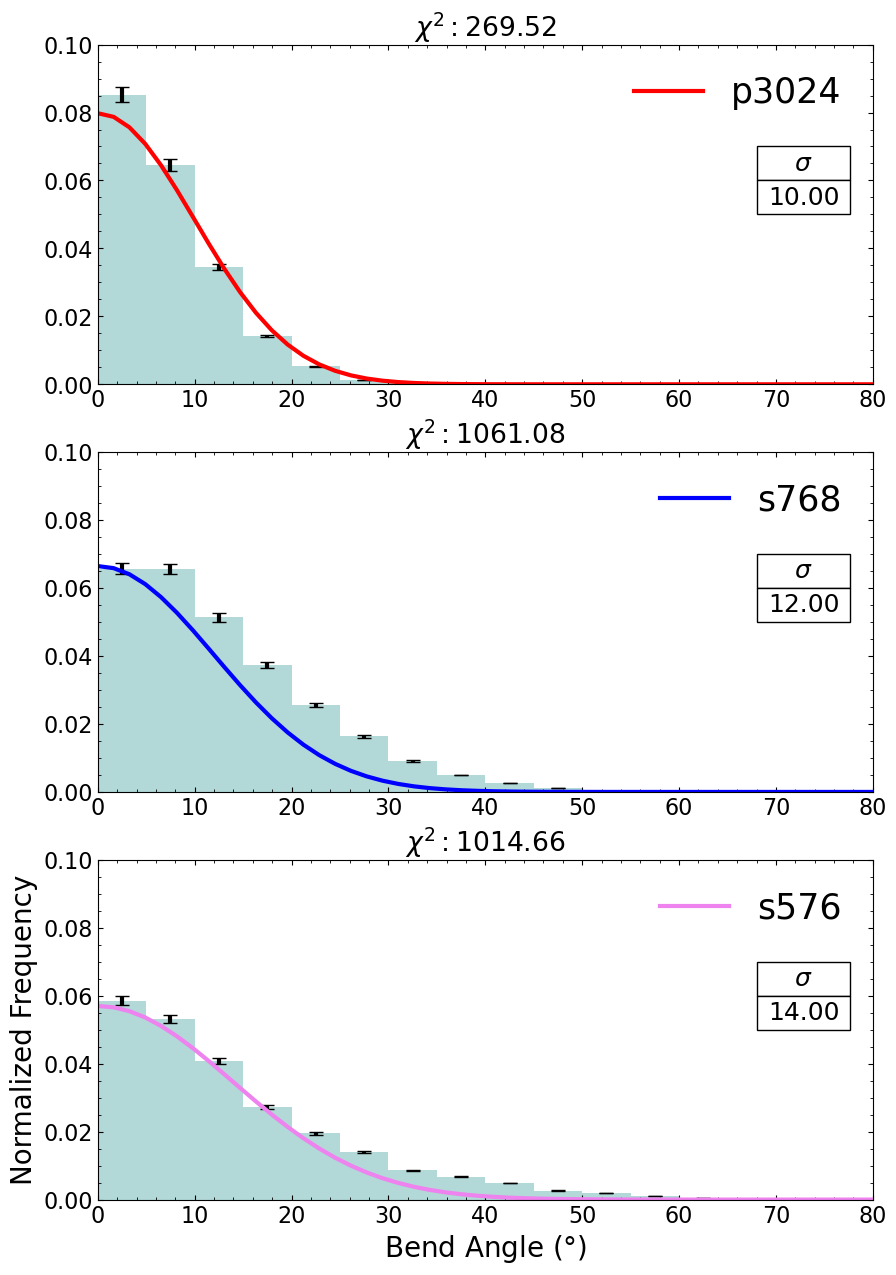

In [152]:
sig0 = [10,12,14,10]
fig, axs = plt.subplots(3, figsize = (10,15))
plot_hist(y_data_sets, y_error_sets, axs)
plot_model_result(sig0, y_data_sets, y_error_sets, axs)
plt.show()

In [10]:
fits = [minimize(chi_square, x0 = sig0[i], args = (y_data_sets[i], y_error_sets[i])) for i in range(len(seed_len_types))]

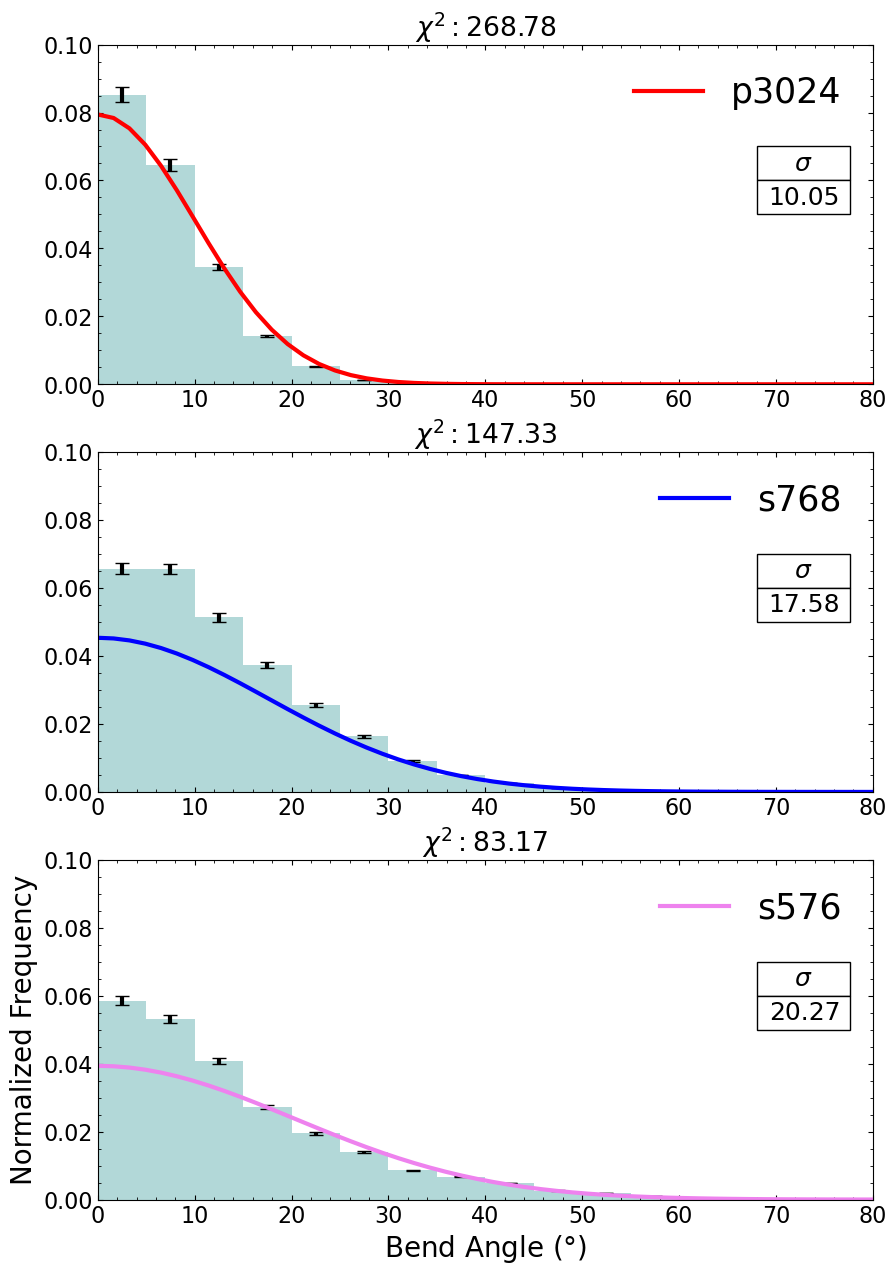

In [153]:
fig, axs = plt.subplots(3, figsize = (10,15))
plot_hist(y_data_sets, y_error_sets, axs)
plot_model_result([fit.x[0] for fit in fits], y_data_sets, y_error_sets, axs)
plt.show()

In [12]:
def bootstrap_data(angle_dist):
    new_angle_dist = []
    for _ in range(len(angle_dist)):
        new_angle_dist.append(random.choice(angle_dist))
    return new_angle_dist

def get_boot_fit(angle_dist, sig0):
    boot_angle_dist = bootstrap_data(angle_dist)
    y_data = get_y_data(boot_angle_dist)
    y_error = get_y_error(boot_angle_dist)
    fit_result = minimize(chi_square, x0 = sig0, args = (y_data, y_error))
    
    return fit_result.x, y_data, y_error

In [13]:
num_boot = 10
bootstrap_results = [get_boot_fit(angle_dists[i], sig0[i]) for i in range(4) for _ in range(num_boot)]

In [14]:
def plot_bootstrap_results(bootstrap_results, num_boot, c = 'teal'):
    fig, axs = plt.subplots(num_boot, 4, figsize = (25,5*num_boot))
    means = []
    std = []
    for i in range(4):
        sig = []
        for n in range(num_boot):
            fit, y_data, y_error = bootstrap_results[n + i*num_boot]
            sig.append(fit[0])

            axs[n, i].bar(x_data, y_data, alpha = 0.3, color = c, yerr = y_error, width = 5, capsize = 5)
            axs[n, i].plot(np.linspace(0,80), foldnorm.pdf(np.linspace(0,80), 0, scale = fit[0]), color = colors[i], label = seed_len_types[i])

            chi_sq = chi_square(fit[0], y_data, y_error)

            axs[n, i].set_title(f'$\chi^2 = {chi_sq:.2f}$, $\sigma = {fit[0]:.2f}$')

        means.append(np.mean(sig))
        std.append(np.std(sig))
        print(f'{seed_len_types[i]} sigma: {np.mean(sig):.2e} +- {np.std(sig):.2e}')

    return means, std

p3024 sigma: 9.39e+00 +- 1.40e-01
s768 sigma: 1.69e+01 +- 7.74e-01
s576 sigma: 2.11e+01 +- 5.99e-01
s384 sigma: 1.28e+01 +- 2.80e-01


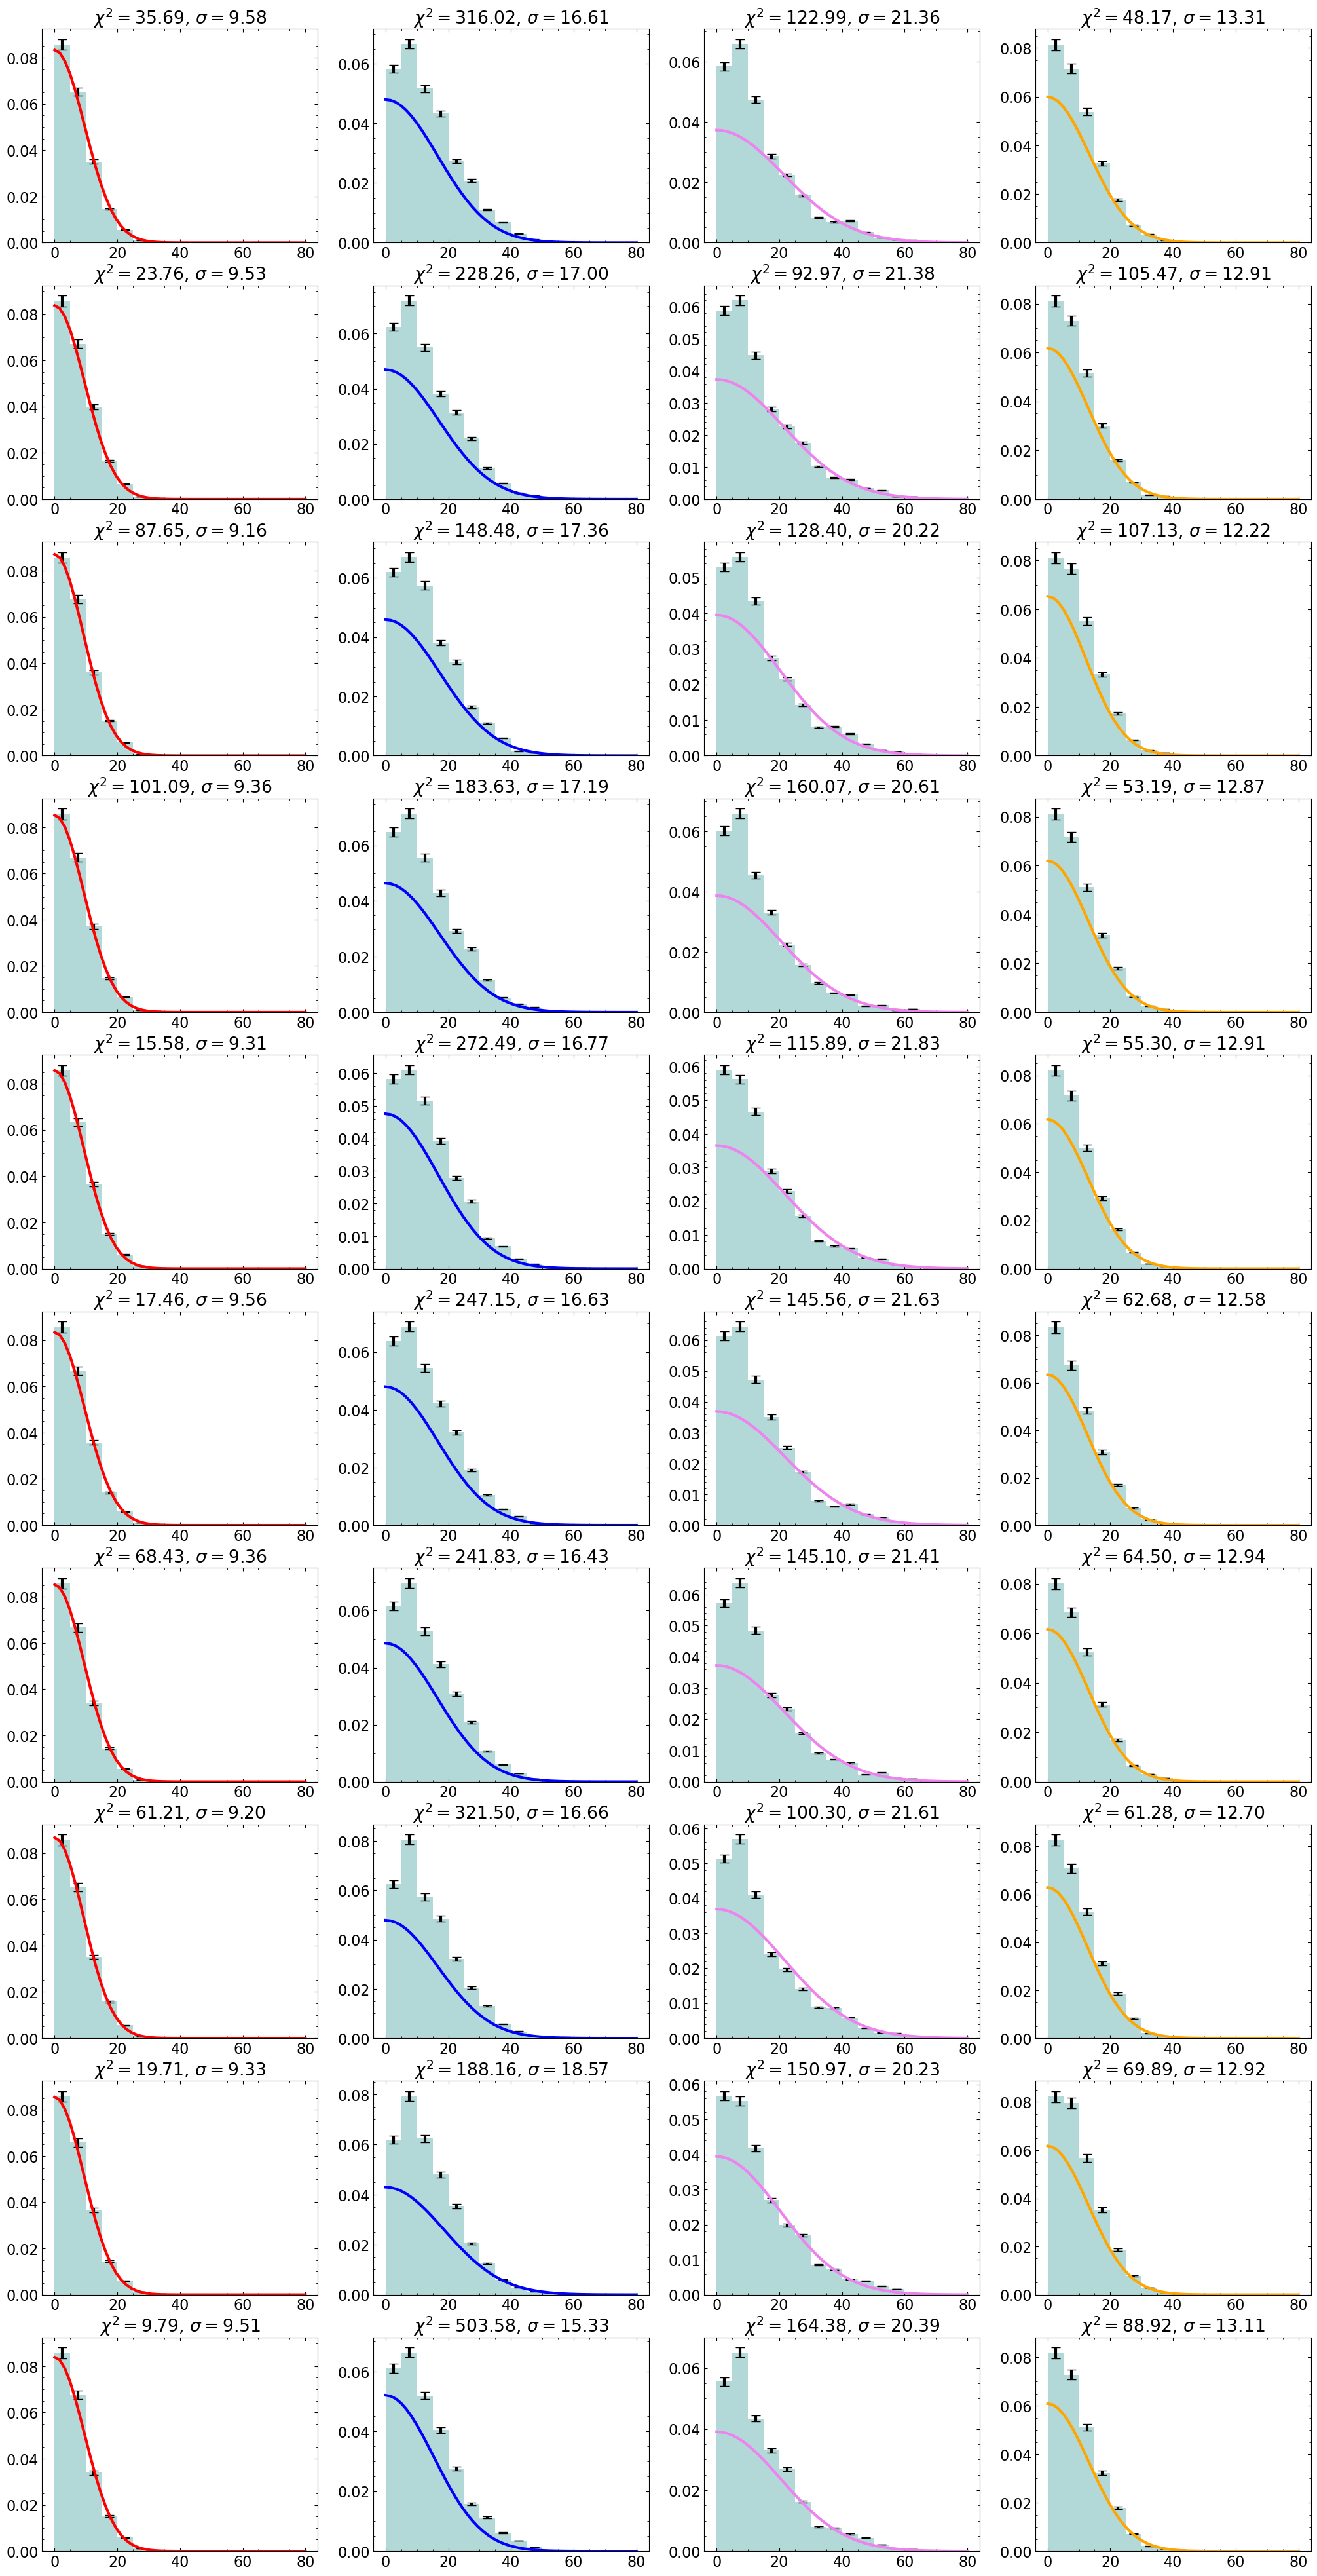

In [15]:
means, std = plot_bootstrap_results(bootstrap_results, num_boot) 
plt.show()

In [180]:
flex = [fit.x[0] for fit in fits]
length_data_fit_results = open_json('fit_results.json')
os_fits = [length_data_fit_results[seed]['par'] for seed in seed_len_types]
os_fit_errors = [length_data_fit_results[seed]['error'] for seed in seed_len_types]

ts_re_fits = [length_data_fit_results[f're {seed}']['par'] for seed in seed_len_types]
ts_re_errors = [length_data_fit_results[f're {seed}']['error'] for seed in seed_len_types]

ts_se_fits = [length_data_fit_results[f'se {seed}']['par'] for seed in seed_len_types]
ts_se_errors = [length_data_fit_results[f'se {seed}']['error'] for seed in seed_len_types]

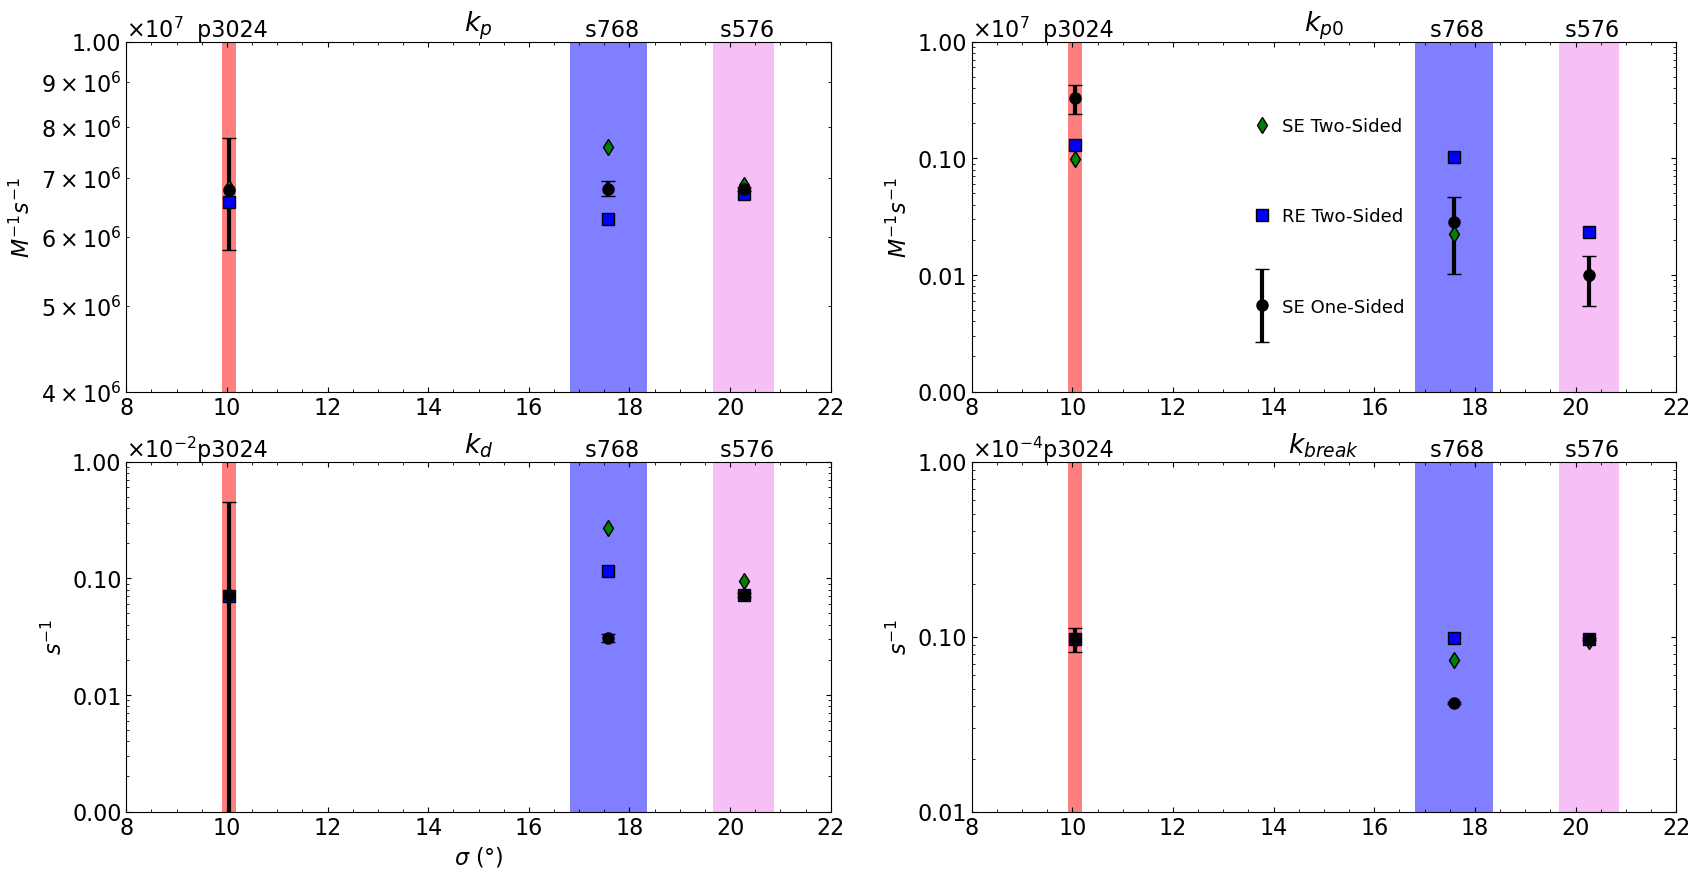

In [196]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
par_names = [r'$k_{p}$', r'$k_{p0}$', r'$k_{d}$', r'$k_{break}$']
shapes = ['o', 's', 'd']
line_colors = ['black', 'b', 'g']
line_style = ['-', '--', ':']
all_fits = [os_fits, ts_re_fits, ts_se_fits]
all_errors = [os_fit_errors, ts_re_errors, ts_se_errors]
bar_maxs = [1e7, 1e7, 1e-2, 1e-4]
bar_mins = [4e6, 1e4, 1e-5, 1e-6]
tube_types = ['SE One-Sided', 'RE Two-Sided', 'SE Two-Sided']

for i in range(3): #for seed length
    for j in range(4): #for parameter
        y = [0,0,1,1][j]
        x = [0,1,0,1][j]

        axs[y,x].set_title(par_names[j])

        axs[y,x].bar(flex[i], bar_maxs[j], color = colors[i], alpha = 0.5, zorder = 1, width = 2 * std[i])
        #axs[y,x].bar(flex[i], bar_mins[j], color = colors[i], alpha = 0.5, zorder = 1, width = 2 * std[i])
        axs[y,x].bar_label(axs[y,x].containers[0:7:1][i], label_type='edge', labels = [f' {seed_len_types[i]}']) #change container 1 to 2 if I add the row above back
        axs[y,x].margins(y=0.1)
        axs[y,x].set_yscale("log")
        axs[y,x].set_ylim(bar_mins[j], bar_maxs[j])

err_plots = []
for i in range(3): #for seed length
    for j in range(4): #for parameter
        y = [0,0,1,1][j]
        x = [0,1,0,1][j]
        for k in range(3)[::-1]: #for tube type
            if i == 0:
                label = tube_types[k]
            else:
                label = None
            
            if k == 0: #if one sided data
                err_plot = axs[y,x].errorbar(flex[i], all_fits[k][i][j], yerr = all_errors[k][i][j], capsize = 5, zorder=1, color = line_colors[k], label = label, fmt = shapes[k], markeredgecolor = 'black', markersize = 8)
                err_plot[-1][0].set_linestyle(line_style[k])  
            else:
                err_plot = axs[y,x].errorbar(flex[i], all_fits[k][i][j], capsize = 5, zorder=1, color = line_colors[k], label = label, fmt = shapes[k], markeredgecolor = 'black', markersize = 8)

            if i == 0 and j == 0:
                err_plots.append(err_plot)
        
        yScalarFormatter = ScalarFormatterClass(useMathText=True, useOffset=False)
        yScalarFormatter.set_powerlimits((0,0))
        axs[y,x].yaxis.set_major_formatter(yScalarFormatter)


axs[0,0].set_ylabel('$M^{-1} s^{-1}$')
axs[0,1].set_ylabel('$M^{-1} s^{-1}$')
axs[1,0].set_ylabel('$s^{-1}$')
axs[1,1].set_ylabel('$s^{-1}$')

axs[1,0].set_xlabel('$\sigma$ ($\degree$)')
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim(8, 22)

axs[0,1].legend(
        err_plots, [plot.get_label() for plot in err_plots],
        handler_map={type(err_plot): HandlerErrorbar(xerr_size=2)},  # adjust xerr_size to suit the plot
        labelspacing=4, handletextpad = 0.1, loc = 10,
        frameon=False, fontsize=13)

plt.show()